<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE30338](https://jckantor.github.io/CBE30338)
by Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE30338.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Simulation, Control, and Estimation using Pyomo](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/B.13-Optimization-Control-and-Estimation-using-Pyomo.ipynb) | [Contents](toc.ipynb) | [Student Projects](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/C.00-Student-Projects.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/B.14-Optimization-Control-and-Estimation-using-Pyomo-With-Windows-ipopt.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE30338/master/notebooks/B.14-Optimization-Control-and-Estimation-using-Pyomo-With-Windows-ipopt.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Simulation, Control, and Estimation using Pyomo

## Installations

The following instructions show how to download and install pyomo and the ipopt solver.  Execute the appropriate cell for your platform (if needed).

### Google Colab

In [1]:
!pip install -q pyomo
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
ipopt_executable = '/content/ipopt'

/bin/sh: wget: command not found
unzip:  cannot find or open ipopt-linux64, ipopt-linux64.zip or ipopt-linux64.ZIP.


### MacOS

In [2]:
!pip install -q pyomo
!curl -s https://ampl.com/dl/open/ipopt/ipopt-osx.zip --output ipopt-osx.zip
!tar xf ipopt-osx.zip ipopt
ipopt_executable = "./ipopt"
!rm ipopt-osx.zip

### Windows PC

In [11]:
!conda install -c conda-forge pyomo pyomo.extras
!conda install -c conda-forge/label/cf201901 ipopt 

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



## Process Information

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H) 
\end{align*}


### Process Parameter Values

In [7]:
P = 0.04        # power input when the system is turned
Ua = 0.068      # heat transfer coefficient from heater to environment
CpH = 6.50      # heat capacity of the heater (J/deg C)
CpS = 1.25      # heat capacity of the sensor (J/deg C)
Uc = 0.036      # heat transfer coefficient from heater to sensor
Tamb = 21.0     # ambient room temperature

### Process Inputs

The next cell defines some process inputs that will be used throughout the notebook to demonstrate aspects of process simulation, control, and estimation.  These are gathered in one place to make it easier to modify the notebook to test the response under different conditions. These functions are implemented using the `interp1d` from the `scipy` library.

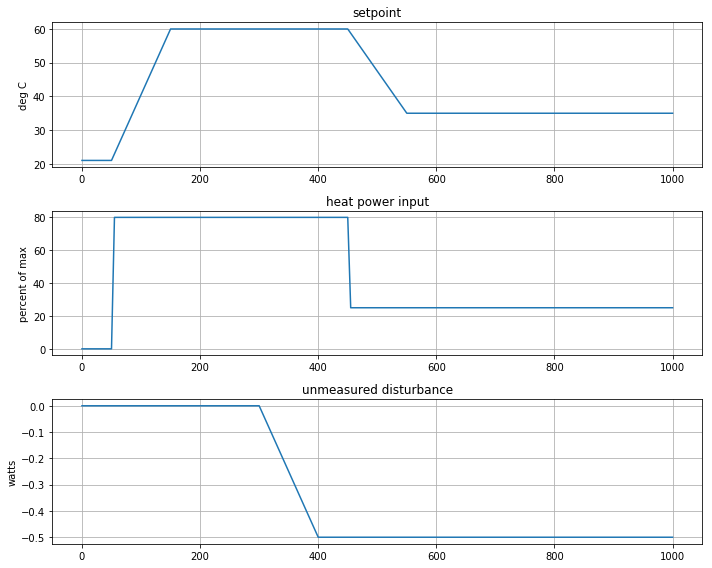

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np

tclab_disturbance = interpolate.interp1d(
    [ 0, 300, 400, 9999], 
    [ 0, 0, -.5, -.5])

tclab_input = interpolate.interp1d(
    [ 0, 50, 51, 450, 451, 9999],
    [ 0,  0, 80,  80,   25,   25])

tclab_setpoint = interpolate.interp1d(
    [0, 50, 150, 450, 550, 9999], 
    [Tamb, Tamb, 60, 60, 35, 35])

t_sim = np.linspace(0, 1000, 201)
u_sim = tclab_input(t_sim)
d_sim = tclab_disturbance(t_sim)
setpoint_sim = tclab_setpoint(t_sim)

plt.figure(figsize=(10,8))
plt.subplot(3, 1, 1)
plt.plot(t_sim, setpoint_sim)
plt.title('setpoint')
plt.ylabel('deg C')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_sim, u_sim)
plt.title('heat power input')
plt.ylabel('percent of max')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_sim, d_sim)
plt.title('unmeasured disturbance')
plt.ylabel('watts')
plt.grid(True)

plt.tight_layout()

## Pyomo Simulation

Let's see how well our initial guess at a control strategy will work for us.

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H) 
\end{align*}

subject to initial conditions

\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}

and prior specification of inputs $u(t)$ and $d(t)$.

    of finite elements specified in apply. The larger number of finite
    elements will be used.


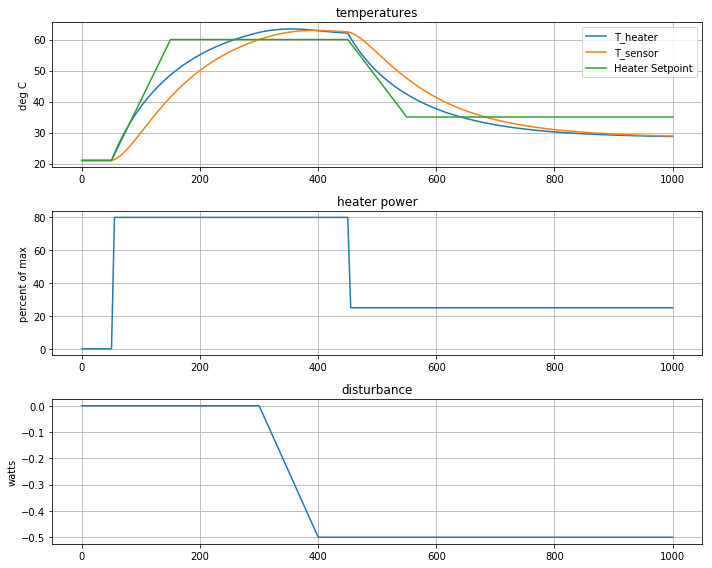

In [13]:
from pyomo.environ import *
from pyomo.dae import *


m = ConcreteModel()
m.t = ContinuousSet(initialize = t_sim)  # make sure the expt time grid are discretization points
m.Th = Var(m.t)
m.Ts = Var(m.t)
m.U = Var(m.t, bounds=(0, 100))
m.D = Var(m.t)

m.Thdot = DerivativeVar(m.Th, wrt = m.t)
m.Tsdot = DerivativeVar(m.Ts, wrt = m.t)

# differential equations
m.Th_ode = Constraint(m.t, rule = lambda m, t: 
                      CpH*m.Thdot[t] == Ua*(Tamb - m.Th[t]) + Uc*(m.Ts[t] - m.Th[t]) + P*m.U[t] + m.D[t])
m.Ts_ode = Constraint(m.t, rule = lambda m, t: 
                      CpS*m.Tsdot[t] == Uc*(m.Th[t] - m.Ts[t]))

# input specifications
m.Usim = Constraint(range(0, len(t_sim)), rule = lambda m, k: m.U[t_sim[k]] == u_sim[k])
m.Dsim = Constraint(range(0, len(t_sim)), rule = lambda m, k: m.D[t_sim[k]] == d_sim[k])

# initial conditions
m.Th[0].fix(Tamb)
m.Ts[0].fix(Tamb)

TransformationFactory('dae.finite_difference').apply_to(m, method='forward')
SolverFactory('ipopt').solve(m)

Th_sim = np.array([m.Th[t]() for t in t_sim])
Ts_sim = np.array([m.Ts[t]() for t in t_sim])

# visualization
plt.figure(figsize=(10,8))
plt.subplot(3, 1, 1)
plt.plot(t_sim, Th_sim)
plt.plot(t_sim, Ts_sim)
plt.plot(t_sim, setpoint_sim)
plt.title('temperatures')
plt.ylabel('deg C')
plt.legend(['T_heater', 'T_sensor', 'Heater Setpoint'])
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_sim, np.array([m.U[t]() for t in t_sim]))
plt.title('heater power')
plt.ylabel('percent of max')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_sim, np.array([m.D[t]() for t in t_sim]))
plt.title('disturbance')
plt.ylabel('watts')
plt.grid(True)

plt.tight_layout()

## Optimal Control with Knowledge of Disturbances

An optimal control policy minimizes the differences

\begin{align*}
\min_{u} \int_{t_0}^{t_f} \|T_H^{SP}(t) - T_H(t)\|^2\,dt \\
\end{align*}

subject to constraints

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H) 
\end{align*}

initial conditions

\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}

and prior knowledge of $d(t)$.

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1007
  Number of variables: 1210
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.27823472023010254
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


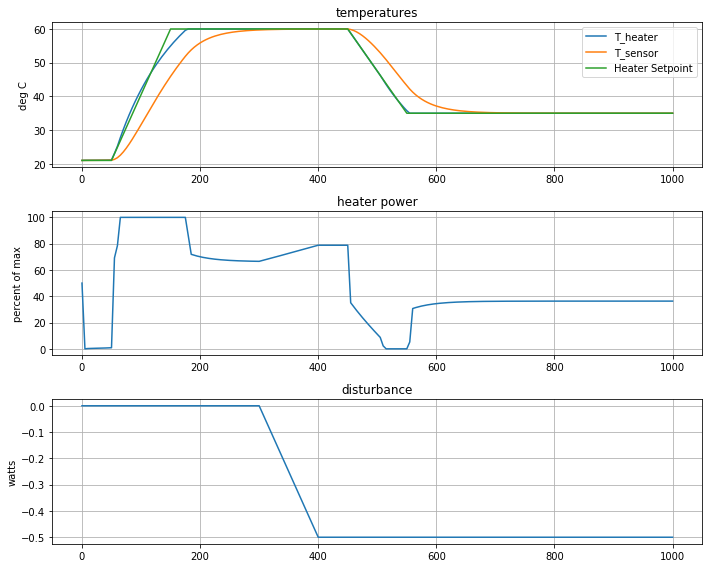

In [21]:
#%%time  #if you put this as the first line, jupyter will report how long the code took to execute. 

from pyomo.environ import *
from pyomo.dae import *

m = ConcreteModel()
m.t = ContinuousSet(initialize = t_sim)  # make sure the expt time grid are discretization points
m.Th = Var(m.t)
m.Ts = Var(m.t)
m.U = Var(m.t, bounds=(0, 100))
m.D = Var(m.t)

m.Thdot = DerivativeVar(m.Th, wrt = m.t)
m.Tsdot = DerivativeVar(m.Ts, wrt = m.t)

# differential equations
m.Th_ode = Constraint(m.t, rule = lambda m, t: 
                      CpH*m.Thdot[t] == Ua*(Tamb - m.Th[t]) + Uc*(m.Ts[t] - m.Th[t]) + P*m.U[t] + m.D[t])
m.Ts_ode = Constraint(m.t, rule = lambda m, t: 
                      CpS*m.Tsdot[t] == Uc*(m.Th[t] - m.Ts[t]))

# input specifications
m.Dsim = Constraint(range(0, len(t_sim)), rule = lambda m, k: m.D[t_sim[k]] == d_sim[k])

# with these two lines which provide an objective function to determine the input
m.ls_control = sum([(setpoint_sim[k] - m.Th[t_sim[k]])**2 for k in range(0, len(t_sim))])
m.obj = Objective(expr = m.ls_control, sense=minimize)

# initial conditions
m.Th[0].fix(Tamb)
m.Ts[0].fix(Tamb)

TransformationFactory('dae.finite_difference').apply_to(m, nfe=len(t_sim), method='forward')
SolverFactory('ipopt').solve(m).write()

# visualization
plt.figure(figsize=(10,8))
plt.subplot(3, 1, 1)
plt.plot(t_sim, np.array([m.Th[t]() for t in t_sim]))
plt.plot(t_sim, np.array([m.Ts[t]() for t in t_sim]))
plt.plot(t_sim, setpoint_sim)
plt.title('temperatures')
plt.ylabel('deg C')
plt.legend(['T_heater', 'T_sensor', 'Heater Setpoint'])
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_sim, np.array([m.U[t]() for t in t_sim]))
plt.title('heater power')
plt.ylabel('percent of max')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_sim, np.array([m.D[t]() for t in t_sim]))
plt.title('disturbance')
plt.ylabel('watts')
plt.grid(True)

plt.tight_layout()

### Exercise

The optimal control computed above requires rapid changes in power level. In process systems where control action requires movement of a valve stem position, there are often limits on how fast the manipulated variable can change. Modify the model to include differential inequalities that limit the time rate of change of control.

\begin{align*}
\frac{du}{dt} & \leq \dot{u}_{max} \\
\frac{du}{dt} & \geq -\dot{u}_{max}
\end{align*}

where $\dot{u}_{max}$ is the maximum rate of change. 

## Estimation/Observation

> "... and now my watch begins ..." ―The Night's Watch oath, Game of Thrones

The trouble with open-loop optimal control is that we can't anticipate or know the values of unmeasured disturbances, much less the future values of those disturbances. The best we can do is use available data and process models to estimate the process state and disturbances. The est


\begin{align*}
\min_{\hat{T}_H, \hat{T}_S, \hat{d}} \int_{t - h}^t \|\hat{T}_S(t) - T_S(t)\|^2\,dt \\
\end{align*}

subject to

\begin{align*}
C_p^H \frac{d\hat{T}_H}{dt} & = U_a (T_{amb} - \hat{T}_H) + U_c (\hat{T}_S - \hat{T}_H) + P u(t) + \hat{d}(t)\\
C_p^S \frac{d\hat{T}_S}{dt} & = - U_c (\hat{T}_S - \hat{T}_H) 
\end{align*}

and initial conditions

\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1007
  Number of variables: 1210
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.21533441543579102
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Wa

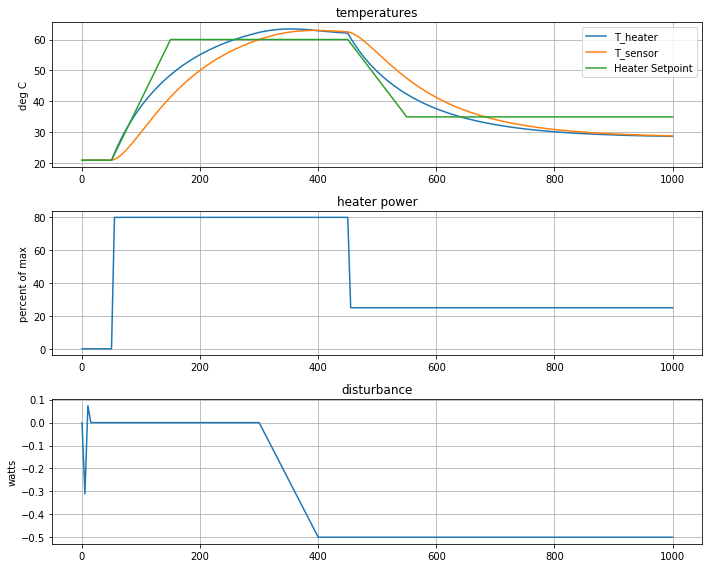

In [17]:
%%time 

from pyomo.environ import *
from pyomo.dae import *

m = ConcreteModel()
m.t = ContinuousSet(initialize = t_sim)  # make sure the expt time grid are discretization points
m.Th = Var(m.t)
m.Ts = Var(m.t)
m.U = Var(m.t, bounds=(0, 100))
m.D = Var(m.t)

m.Thdot = DerivativeVar(m.Th, wrt = m.t)
m.Tsdot = DerivativeVar(m.Ts, wrt = m.t)

# differential equations
m.Th_ode = Constraint(m.t, rule = lambda m, t: 
                      CpH*m.Thdot[t] == Ua*(Tamb - m.Th[t]) + Uc*(m.Ts[t] - m.Th[t]) + P*m.U[t] + m.D[t])
m.Ts_ode = Constraint(m.t, rule = lambda m, t: 
                      CpS*m.Tsdot[t] == Uc*(m.Th[t] - m.Ts[t]))

m.Usim = Constraint(range(0, len(t_sim)), rule = lambda m, k: m.U[t_sim[k]] == u_sim[k])
#for k in range(0, len(t_sim)):
#    m.U[t_sim[k]]

m.ls_observer = sum([(m.Ts[t_sim[k]] - Ts_sim[k])**2 for k in range(0, len(t_sim))])
m.obj = Objective(expr = m.ls_observer, sense=minimize)

m.Th[0].fix(Tamb)
m.Ts[0].fix(Tamb)

TransformationFactory('dae.finite_difference').apply_to(m, nfe=len(t_sim), method='forward')
SolverFactory('ipopt').solve(m).write()

# visualization
plt.figure(figsize=(10,8))
plt.subplot(3, 1, 1)
plt.plot(t_sim, np.array([m.Th[t]() for t in t_sim]))
plt.plot(t_sim, np.array([m.Ts[t]() for t in t_sim]))
plt.plot(t_sim, setpoint_sim)
plt.title('temperatures')
plt.ylabel('deg C')
plt.legend(['T_heater', 'T_sensor', 'Heater Setpoint'])
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_sim, np.array([m.U[t]() for t in t_sim]))
plt.title('heater power')
plt.ylabel('percent of max')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_sim, np.array([m.D[t]() for t in t_sim]))
plt.title('disturbance')
plt.ylabel('watts')
plt.grid(True)

plt.tight_layout()

## Coding the Observer as a Python Generator

In [22]:
from pyomo.environ import *
from pyomo.dae import *

def tclab_observer(h=2):
    t_hist = [-1]
    u_hist = [0]
    Ts_hist = [Tamb]
    
    t_est = -1
    Th_est = []
    Ts_est = []
    d_est = []
    
    while True:
        t_meas, u_meas, Ts_meas = yield t_est, Th_est, Ts_est, d_est
  
        t_hist.append(t_meas)
        u_hist.append(u_meas)
        Ts_hist.append(Ts_meas)
        
        t_hist = t_hist[-h:]
        u_hist = u_hist[-h:]
        Ts_hist = Ts_hist[-h:]
        
        m = ConcreteModel()
        m.t = ContinuousSet(initialize = t_hist)
        m.Th = Var(m.t)
        m.Ts = Var(m.t)
        m.U = Var(m.t, bounds=(0, 100))
        m.D = Var(m.t)

        m.Thdot = DerivativeVar(m.Th, wrt = m.t)
        m.Tsdot = DerivativeVar(m.Ts, wrt = m.t)

        m.Th_ode = Constraint(m.t, rule = lambda m, t: 
                          CpH*m.Thdot[t] == Ua*(Tamb - m.Th[t]) + Uc*(m.Ts[t] - m.Th[t]) + P*m.U[t] + m.D[t])
        m.Ts_ode = Constraint(m.t, rule = lambda m, t: 
                          CpS*m.Tsdot[t] == Uc*(m.Th[t] - m.Ts[t]))

        m.Usim = Constraint(range(0, len(t_hist)), rule = lambda m, k: m.U[t_hist[k]] == u_hist[k])

        m.ls_observer = sum([(m.Ts[t_hist[k]] - Ts_hist[k])**2 for k in range(0, len(t_hist))])
        m.obj = Objective(expr = m.ls_observer, sense=minimize)

        TransformationFactory('dae.finite_difference').apply_to(m, nfe=len(t_hist), method='forward')
        SolverFactory('ipopt').solve(m)
    
        t_est = t_hist[-1]
        Th_est = m.Th[t_est]()
        Ts_est = m.Ts[t_est]()
        d_est = m.D[t_est]()

CPU times: user 2.53 s, sys: 1.37 s, total: 3.9 s
Wall time: 6.29 s


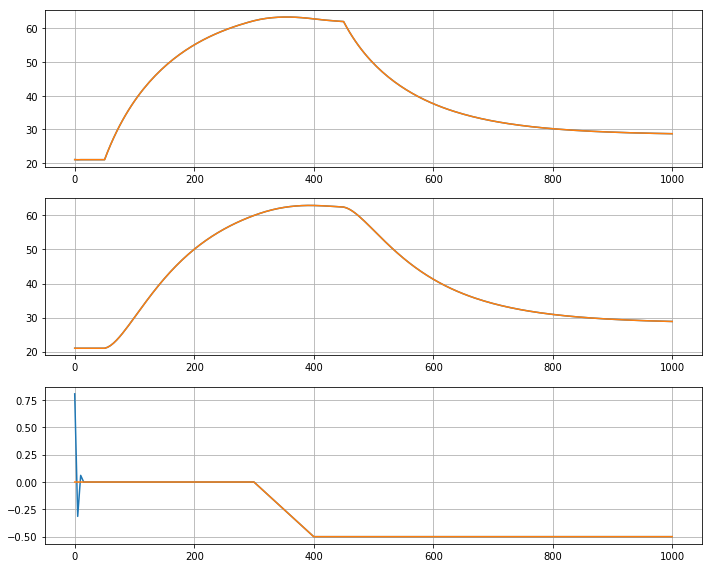

In [11]:
%%time

t_est = []
Th_est = []
Ts_est = []
d_est = []

observer = tclab_observer(5)
observer.send(None)

for k in range(0, len(t_sim)):
    t, Th, Ts, d = observer.send([t_sim[k], u_sim[k], Ts_sim[k]])
    t_est.append(t)
    Th_est.append(Th)
    Ts_est.append(Ts)
    d_est.append(d)
    
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(t_est, Th_est)
plt.plot(t_sim, Th_sim)
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t_est, Ts_est)
plt.plot(t_sim, Ts_sim)
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t_est, d_est)
plt.plot(t_sim, d_sim)
plt.grid(True)

plt.tight_layout()

## Coding the Controller as a Python Generator

C:\Users\eliza\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  del sys.path[0]


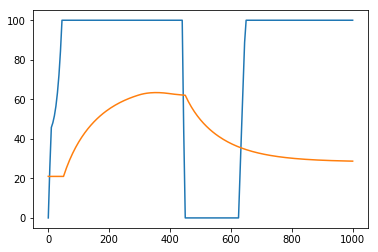

In [23]:
from pyomo.environ import *
from pyomo.dae import *

def tclab_control(h=100):
    
    u = 0
    
    while True:
        t_est, Th_est, Ts_est, d_est = yield u
        
        tf = t_est + h
        m = ConcreteModel()
        m.t = ContinuousSet(initialize=np.linspace(t, tf, 1 + round((tf-t)/2)))
        m.Th = Var(m.t)
        m.Ts = Var(m.t)
        m.U = Var(m.t, bounds=(0, 100))
        m.Thdot = DerivativeVar(m.Th, wrt = m.t)
        m.Tsdot = DerivativeVar(m.Ts, wrt = m.t)
        m.heater = Constraint(m.t, rule = lambda m, t: 
                          CpH*m.Thdot[t] == Ua*(Tamb - m.Th[t]) + Uc*(m.Ts[t] - m.Th[t]) + P*m.U[t] + d)
        m.sensor = Constraint(m.t, rule = lambda m, t: 
                          CpS*m.Tsdot[t] == Uc*(m.Th[t] - m.Ts[t]))
        m.Th[t].fix(Th_est)
        m.Ts[t].fix(Ts_est)
        m.obj = Objective(expr = sum([(tclab_setpoint(t) - m.Th[t])**2 for t in m.t]), sense=minimize)
        TransformationFactory('dae.finite_difference').apply_to(m, nfe=len(m.t), method='backwards')
        SolverFactory('ipopt').solve(m)
        
        umpc = np.array([m.U[t]() for t in m.t])
        u = umpc[1]

observer = tclab_observer(3)
observer.send(None)

controller = tclab_control()
controller.send(None)


t_mpc = []
u_mpc = []
Th_mpc = []
Ts_mpc = []


for k in range(0, len(t_sim)):
    t, Th, Ts, d = observer.send([t_sim[k], u_sim[k], Ts_sim[k]])
    u = controller.send([t, Th, Ts, d])
    u_mpc.append(u)
    Th_mpc.append(Th)
    Ts_mpc.append(Ts)
    
plt.plot(t_sim, u_mpc)
plt.plot(t_sim, Th_mpc)

In [22]:
len(t_sim)

201

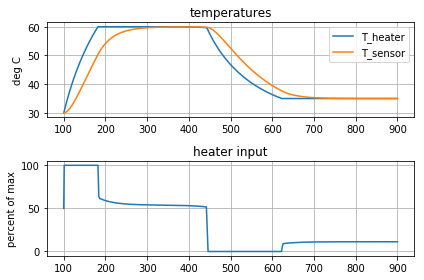

In [190]:
def tclab_control(t, h, ic, d):
    tf = t + h
    
    m = ConcreteModel()
    m.t = ContinuousSet(initialize=np.linspace(t, tf, 1 + round((tf-t)/2)))
    m.Th = Var(m.t)
    m.Ts = Var(m.t)
    m.U = Var(m.t, bounds=(0, 100))
    m.Thdot = DerivativeVar(m.Th, wrt = m.t)
    m.Tsdot = DerivativeVar(m.Ts, wrt = m.t)
    m.heater = Constraint(m.t, rule = lambda m, t: 
                      CpH*m.Thdot[t] == Ua*(Tamb - m.Th[t]) + Uc*(m.Ts[t] - m.Th[t]) + P*m.U[t] + d)
    m.sensor = Constraint(m.t, rule = lambda m, t: 
                      CpS*m.Tsdot[t] == Uc*(m.Th[t] - m.Ts[t]))
    m.Th[t].fix(ic[0])
    m.Ts[t].fix(ic[1])
    m.obj = Objective(expr = sum([(tclab_setpoint(t) - m.Th[t])**2 for t in m.t]), sense=minimize)
    TransformationFactory('dae.finite_difference').apply_to(m, nfe=len(m.t), method='backwards')
    SolverFactory('ipopt').solve(m)
    tsim = np.array([t for t in m.t])
    Thsim = np.array([m.Th[t]() for t in m.t])
    Tssim = np.array([m.Ts[t]() for t in m.t])
    Usim = np.array([m.U[t]() for t in m.t])
    return [tsim, Usim, Thsim, Tssim]
    
[tsim, Usim, Thsim, Tssim] = tclab_control(100, 800, [30, 30], .5)
    
# visualization

plt.subplot(2,1,1)
plt.plot(tsim, Thsim, tsim, Tssim)
plt.title('temperatures')
plt.ylabel('deg C')
plt.legend(['T_heater', 'T_sensor'])
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(tsim, Usim)
plt.title('heater input')
plt.ylabel('percent of max')
plt.grid(True)

plt.tight_layout()

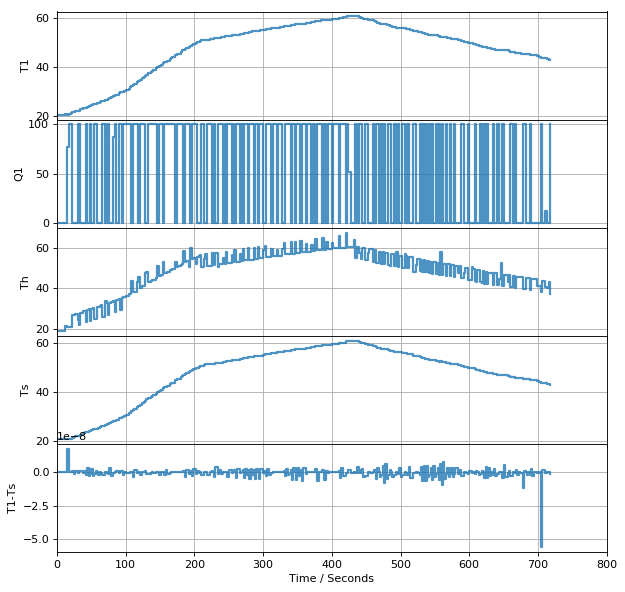

TCLab Model disconnected successfully.


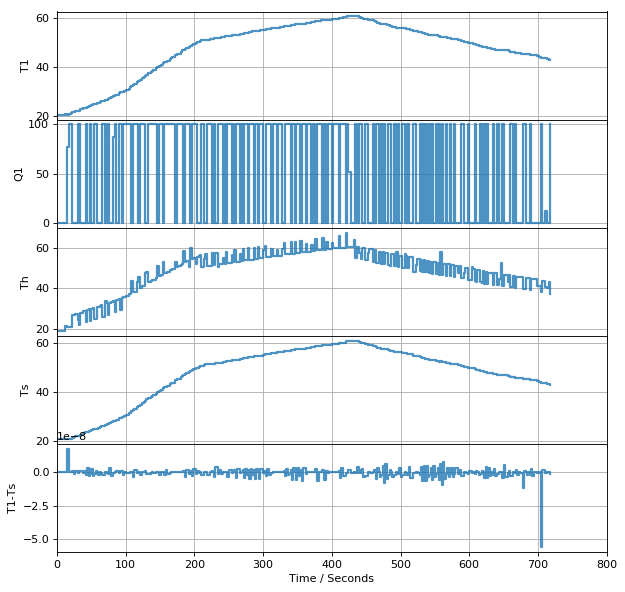

In [24]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

tf = 800        # run time

# create a controller instance
controller = tclab_control(100)
controller.send(None)

# create an model estimator
observer = tclab_observer(5)
observer.send(None)

# execute the event loop
tf = 800
with TCLab() as lab:
    h = Historian([('T1', lambda: lab.T1), ('Q1', lab.Q1),
                   ('Th', lambda: Th), ('Ts', lambda: Ts)])
    p = Plotter(h, tf)
    U1 = 0
    for t in clock(tf, 5):                    # allow time for more calculations
        T1 = lab.T1                           # measure the sensor temperature
        t, Th, Ts, d = observer.send([t, U1, T1])  # estimate the heater temperature                      # get setpoint
        U1 = controller.send([t, Th, Ts, d])        # compute control action
        lab.U1 = U1                           # set manipulated variable  
        p.update(t)                           # log data


<!--NAVIGATION-->
< [Simulation, Control, and Estimation using Pyomo](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/B.13-Optimization-Control-and-Estimation-using-Pyomo.ipynb) | [Contents](toc.ipynb) | [Student Projects](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/C.00-Student-Projects.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/B.14-Optimization-Control-and-Estimation-using-Pyomo-With-Windows-ipopt.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE30338/master/notebooks/B.14-Optimization-Control-and-Estimation-using-Pyomo-With-Windows-ipopt.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>